### Event Selection Optimization - Caleb Wilkins 12/6/21

In [1]:
# imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pickle
import h5py
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['pcolor.shading'] = 'auto';

This notebook utilizes data that simulates the Large Hadron Collider (LHC) particle accelerator. In this project we are going to look at an inclusive search for the standard model Higgs boson in proton-proton collisions at $\sqrt{s} = 13$ TeV at the LHC. The Higgs bosons are produced with large transverse momentum (pT) and decaying to a bottom quark-antiquark pair.  Due to large QCD background contamination, the direct 5-sigma observation of this Higgs channel is not accomplished yet. We are going to use a set of datasets to optimize event selections in order to enhance the discovery sensitivity.

In [2]:
# Reading in the data we will be working with
qcd = pickle.load(open("./qcd_100000_pt_1000_1200.pkl", 'rb'))
higgs = pickle.load(open("./higgs_100000_pt_1000_1200.pkl",'rb'))

We will begin by making a stacked histogram plot for the feature variable we want to study, mass. We will use the Poisson statistics techniques to calculate a significance without any event selection. Further, we will use a given approximation for the significance to compare our calculation to, which is expressed as $\frac{N_{Higgs}}{\sqrt{N_{QCD}}}$.

In [3]:
higgs_mass = higgs['mass']
qcd_mass = qcd['mass']

First, let us observe the Higgs and QCD background data simply overplotted, to locate their respective means.

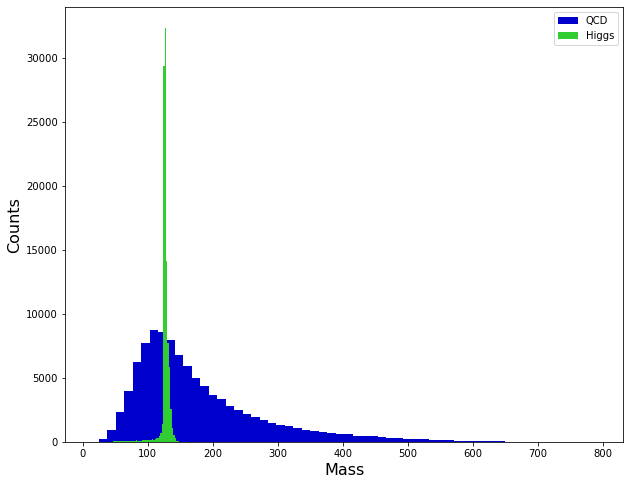

The mean of the Higgs signal is:  126.66383222477353
The mean of the QCD background is:  177.2731314354495


In [4]:
plt.hist(qcd_mass, 60, label='QCD', color='MediumBlue')
plt.hist(higgs_mass, 60, label='Higgs', color='LimeGreen')
plt.ylabel("Counts", fontsize=16)
plt.xlabel("Mass", fontsize=16)
plt.legend(loc=0)
plt.show()

print("The mean of the Higgs signal is: ", np.mean(higgs_mass))
print("The mean of the QCD background is: ", np.mean(qcd_mass));

This shows that our plot for the Higgs data is centered around 126.664, roughly the mass of the Higgs Boson.

The ratio of $\frac{N_{Higgs}}{\sqrt{N_{QCD}}}$ represents the ratio of the number of Higgs particles in our data set vs the standard deviation of the QCD background.

In [5]:
# These values were conveniently provided with the LHC dataset
N_higgs = 50 
N_qcd = 2000 
N_data = 100_000
N_total = N_higgs + N_qcd

prob = stats.norm.ppf(stats.poisson.cdf(N_total, N_qcd))
print('Significance:',prob)

ratio = N_higgs / (N_qcd**(1/2))
print('Ratio:', ratio)

Significance: 1.1282230087754428
Ratio: 1.118033988749895


Without event selction, the significance is only 12.8%. Translated to more generally understandable terms, this means that about an eighth of the time, we could expect a number of events equal to the number detected or higher.

To approach the problem of making cuts to increase the significance, we must first weight the two distributions given that there are 50 Higgs counts and 2000 QCD counts in our data set. We do this simply by making variables and using the appropriate ratios.

In [6]:
weight_higgs = N_higgs / N_data
weight_qcd = N_qcd / N_data
print('Weighted Higgs:',weight_higgs)
print('Weighted QCD:',weight_qcd)

Weighted Higgs: 0.0005
Weighted QCD: 0.02


We now have all the information about our data we will need to reach our goal, so we can begin our analysis by constructing the stacked histogram plot.

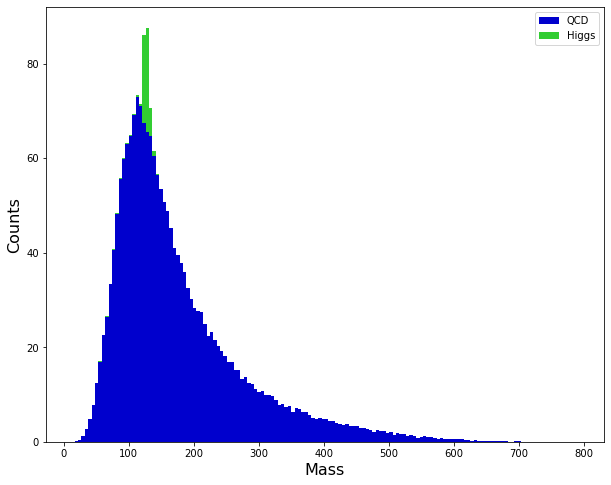

In [7]:
plt.hist([qcd_mass,higgs_mass], 150, stacked=True,
         weights=[(np.ones(qcd_mass.size)*weight_qcd),(np.ones(higgs_mass.size)*weight_higgs)], 
         label=['QCD','Higgs'], color=['MediumBlue','LimeGreen'])
plt.ylabel("Counts", fontsize=16)
plt.xlabel("Mass", fontsize=16)
plt.legend(loc=0)
plt.show();

We can now begin to make cuts from the mass data (or, event selection), which will increase our significance. Though, we must be careful not to cut out too much of our Higgs data when we make these cuts.

In [8]:
def mass_cuts(data, lower, upper):
    bounds = (data['mass'] > lower) & (data['mass'] < upper)
    values = data[bounds]
    return values

def new_yield(data, values, original):
    ratio = len(values)/len(data)
    new_yield = original * ratio
    return new_yield

def approx_significance(higgs_yield, qcd_yield):
    return higgs_yield/np.sqrt(qcd_yield)

Now we must test how close to the mean value of the Higgs data we have to make cuts in order that our significance is as close as possible to a $5\sigma$ significance while not cutting too much of the data.

In [9]:
higgs_cut = mass_cuts(higgs, 120, 130)
qcd_cut = mass_cuts(qcd, 120, 130)
higgs_yield = new_yield(higgs, higgs_cut, 50)
qcd_yield = new_yield(qcd, qcd_cut, 2000)
print(higgs_yield)
print(qcd_yield)
print("The expected significance of this mass cut is:", approx_significance(higgs_yield, qcd_yield))

37.914500000000004
128.28
The expected significance of this mass cut is: 3.3475406344693024


Not the best result, so we'll try again to see if we can do better.

In [10]:
# Trying again because the significance wasn't high enough
higgs_cut = mass_cuts(higgs, 124, 129)
qcd_cut = mass_cuts(qcd, 124, 129)
higgs_yield = new_yield(higgs, higgs_cut, 50)
qcd_yield = new_yield(qcd, qcd_cut, 2000)
print(higgs_yield)
print(qcd_yield)
print("The expected significance of this mass cut is:", approx_significance(higgs_yield, qcd_yield))

33.94
63.26
The expected significance of this mass cut is: 4.267241718150673


This is about as much as we can cut without removing too much of the important Higgs data it seems. Let's plot our optimized data on a semi-log axis in order to gain insight into the behavior of its distribution.

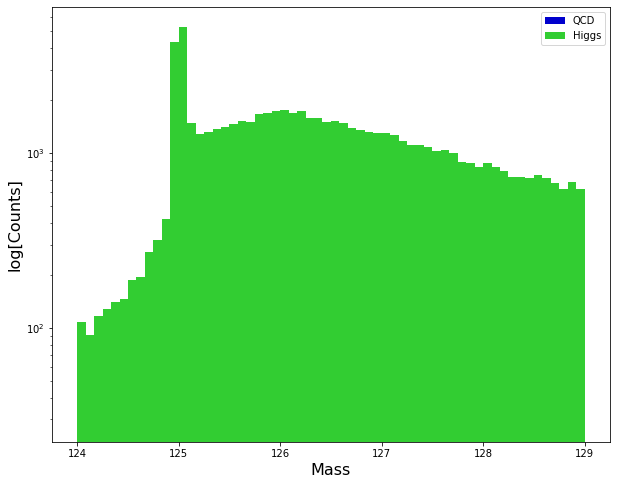

In [11]:
plt.hist(qcd_cut['mass'], 60, label='QCD', color='MediumBlue')
plt.hist(higgs_cut['mass'], 60, label='Higgs', color='LimeGreen')
plt.ylabel("log[Counts]", fontsize=16)
plt.yscale('log')
plt.xlabel("Mass", fontsize=16)
plt.legend(loc=0)
plt.show();

Now, we will show side by side stacked histograms, the left column will be all of the components of our data unchanged (without cuts made) and the right will be all the components of our data with cuts made.

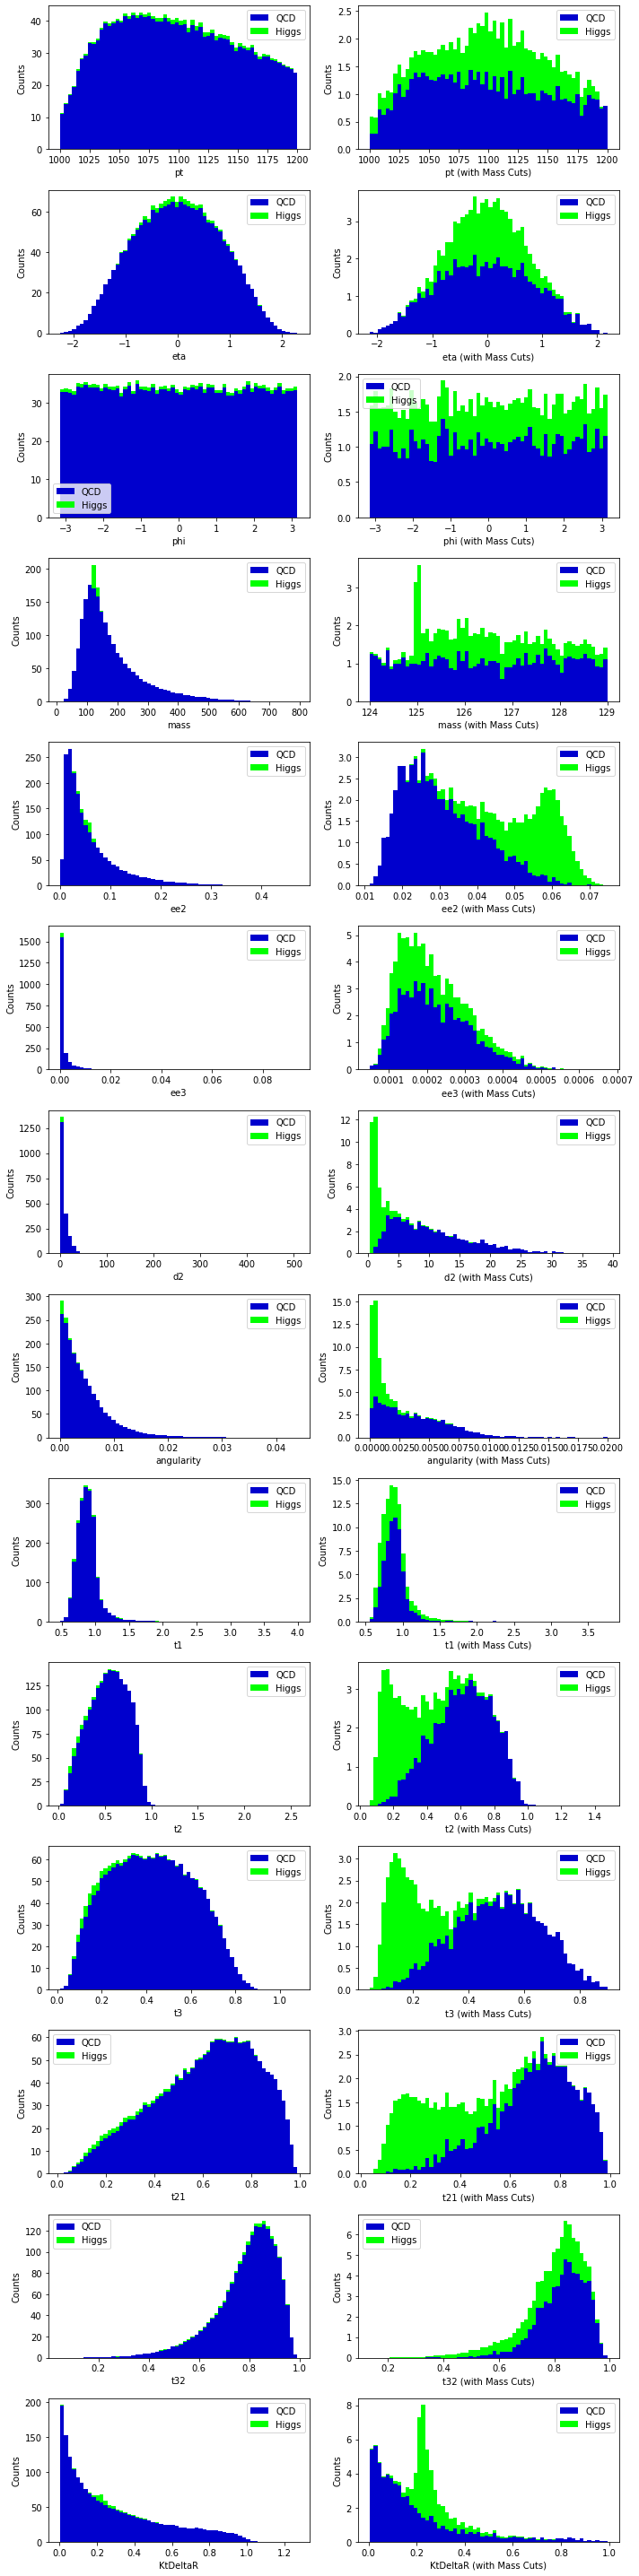

In [12]:
plt.rcParams["figure.figsize"] = (10,40)
fig, ax = plt.subplots(14, 2)

x = 0
for keys in higgs_cut:
    ax[x,0].set_ylabel("Counts")
    ax[x,0].set_xlabel(keys)
    ax[x,0].hist([qcd[keys],higgs[keys]], 60, stacked=True,
                 weights=[(weight_qcd*np.ones(len(qcd_mass))),(weight_higgs*np.ones(len(higgs_mass)))], 
                 label=['QCD','Higgs'], color=['MediumBlue','Lime'])
    ax[x,0].legend(loc=0)
    
    ax[x,1].set_ylabel("Counts")
    ax[x,1].set_xlabel(keys + " (with Mass Cuts)")
    ax[x,1].hist([qcd_cut[keys],higgs_cut[keys]], 60, stacked=True,
                 weights=[(weight_qcd*np.ones(len(qcd_cut))),(weight_higgs*np.ones(len(higgs_cut)))],
                 label=['QCD','Higgs'], color=['MediumBlue','Lime'])
    ax[x,1].legend(loc=0)
    
    x = x + 1
fig.tight_layout()
plt.show();

Visually observing these graphs, the components that show the most discrepency between the Higgs data and the QCD data are 'd2', 'ee2', and 'mass'. After making cuts from these components that could increase our significance, we will recalculate our significance.

In [13]:
# mimicking our mass_cuts function from before for these other components
def d2_cuts(data, lower, upper):
    bounds = (data['d2'] > lower) & (data['d2'] < upper)
    values = data[bounds]
    return values

def ee2_cuts(data, lower, upper):
    bounds = (data['ee2'] > lower) & (data['ee2'] < upper)
    values = data[bounds]
    return values

In [14]:
higgs_d2cut = d2_cuts(higgs_cut, 0, 10)
qcd_d2cut = d2_cuts(qcd_cut, 0, 10)
higgs_d2yield = new_yield(higgs, higgs_d2cut, 50)
qcd_d2yield = new_yield(qcd, qcd_d2cut, 2000)
print(higgs_d2yield)
print(qcd_d2yield)
print("The expected significance is: ", approx_significance(higgs_d2yield, qcd_d2yield))

33.859
35.1
The expected significance is:  5.715057038347645


In [15]:
higgs_ee2cut = ee2_cuts(higgs_d2cut, 0, 0.07)
qcd_ee2cut = ee2_cuts(qcd_d2cut, 0, 0.07)
higgs_ee2yield = new_yield(higgs, higgs_ee2cut, 50)
qcd_ee2yield = new_yield(qcd, qcd_ee2cut, 2000)
print(higgs_ee2yield)
print(qcd_ee2yield)
print("The expected significance is: ", approx_significance(higgs_ee2yield, qcd_ee2yield))

33.637499999999996
35.1
The expected significance is:  5.677670076712805


We brought our significance up from 4.27$\sigma$ to 5.68$\sigma$, which is a believable significance for which we could claim a discovery! 

The main reason that these three components help create the highest significance is because they remove more of the background than the signal, allowing us to get higher expected significance.